<h1><center>Laboratorio 10: Interpretabilidad ü§ñ</center></h1>

<center><strong>MDS7202: Laboratorio de Programaci√≥n Cient√≠fica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebasti√°n Tinoco
- Ayudante: Arturo Lazcano, Angelo Mu√±oz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no ser√°n revisados

- Nombre de alumno 1: Michelle Avenda√±o
- Nombre de alumno 2: Claudia Navarro


### **Link de repositorio de GitHub:** `https://github.com/ClaudiaRayen/MDS7202-Laboratorios/tree/Lab10`

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcci√≥n del laboratorio](#Descripci√≥n-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificaci√≥n usando `XGBoost`.
- M√©todos Agn√≥sticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- M√©todos Agn√≥sticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisar√°n entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente ser√°n respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificaci√≥n con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificaci√≥n.

El laboratorio deber√° ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al m√°ximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante m√°s eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Cl√≠nicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades cr√≥nicas, como la diabetes, decidi√≥ abrir una cl√≠nica especializada en el tratamiento de esta enfermedad en nuestro pa√≠s.

La cl√≠nica del Doctor Simi se convirti√≥ en un lugar donde los pacientes con diabetes podr√≠an recibir atenci√≥n m√©dica integral. El personal m√©dico estaba compuesto por especialistas en endocrinolog√≠a, nutrici√≥n y enfermer√≠a, todos capacitados en el manejo de la diabetes.

Sin embargo √©l se ha dado cuenta que los tiempos han cambiado y gracias a las tecnolog√≠as es posible generar mejores predicciones en la diabetes conociendo el historial m√©dico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus cl√≠nicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rog√≥ que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial m√©dico de las personas en forma de datos tabulares para que usted pueda realizar f√°cilmente la clasificaci√≥n.


In [ ]:
import numpy as np
import pandas as pd


# Si usted est√° utilizando Colabolatory le puede ser √∫til este c√≥digo para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = 'Direcci√≥n donde tiene los archivos en el Drive'
except:
    print('Ignorando conexi√≥n drive-colab')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install shap

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
import warnings
from tabulate import tabulate
from sklearn.metrics import classification_report, confusion_matrix
import shap
import xgboost as xgb



In [ ]:
df = pd.read_csv('/content/diabetes_data.csv')
df.head(4)

Age  Sex  HighChol  CholCheck   BMI  Smoker  HeartDiseaseorAttack  \
0   4.0  1.0       0.0        1.0  26.0     0.0                   0.0   
1  12.0  1.0       1.0        1.0  26.0     1.0                   0.0   
2  13.0  1.0       0.0        1.0  26.0     0.0                   0.0   
3  11.0  1.0       1.0        1.0  28.0     1.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  GenHlth  MentHlth  \
0           1.0     0.0      1.0                0.0      3.0       5.0   
1           0.0     1.0      0.0                0.0      3.0       0.0   
2           1.0     1.0      1.0                0.0      1.0       0.0   
3           1.0     1.0      1.0                0.0      3.0       0.0   

   PhysHlth  DiffWalk  Stroke  HighBP  Diabetes  
0      30.0       0.0     0.0     1.0       0.0  
1       0.0       0.0     1.0     1.0       0.0  
2      10.0       0.0     0.0     0.0       0.0  
3       3.0       0.0     0.0     1.0       0.0

## 2. Clasificaci√≥n de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¬øEs acaso un buen predictor de diabetes?, ¬øQu√© buscan explicar las m√©tricas utilizadas?, ¬ølas m√©tricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elecci√≥n de las features?.

In [ ]:
!pip install xgboost

In [ ]:
non_numeric_columns = df.select_dtypes(['number']).columns
for column in non_numeric_columns:
    print(f"Conteo de valores en '{column}':")
    print(tabulate(df[column].value_counts().reset_index(), headers=['Valor', 'Conteo'], tablefmt='pretty'))

Conteo de valores en 'Age':
+----+-------+---------+
|    | Valor | Conteo  |
+----+-------+---------+
| 0  | 10.0  | 10856.0 |
| 1  |  9.0  | 10112.0 |
| 2  |  8.0  | 8603.0  |
| 3  | 11.0  | 8044.0  |
| 4  |  7.0  | 6872.0  |
| 5  | 13.0  | 5426.0  |
| 6  | 12.0  | 5394.0  |
| 7  |  6.0  | 4648.0  |
| 8  |  5.0  | 3520.0  |
| 9  |  4.0  | 2793.0  |
| 10 |  3.0  | 2049.0  |
| 11 |  2.0  | 1396.0  |
| 12 |  1.0  |  979.0  |
+----+-------+---------+
Conteo de valores en 'Sex':
+---+-------+---------+
|   | Valor | Conteo  |
+---+-------+---------+
| 0 |  0.0  | 38386.0 |
| 1 |  1.0  | 32306.0 |
+---+-------+---------+
Conteo de valores en 'HighChol':
+---+-------+---------+
|   | Valor | Conteo  |
+---+-------+---------+
| 0 |  1.0  | 37163.0 |
| 1 |  0.0  | 33529.0 |
+---+-------+---------+
Conteo de valores en 'CholCheck':
+---+-------+---------+
|   | Valor | Conteo  |
+---+-------+---------+
| 0 |  1.0  | 68943.0 |
| 1 |  0.0  | 1749.0  |
+---+-------+---------+
Conteo de valores en

In [ ]:
suma_nulos_por_columna = df.isnull().sum()
tabla_suma_nulos = pd.DataFrame(suma_nulos_por_columna, columns=['Suma de Valores Nulos'])
print(tabulate(tabla_suma_nulos, headers='keys', tablefmt='pretty'))

+----------------------+-----------------------+
|                      | Suma de Valores Nulos |
+----------------------+-----------------------+
|         Age          |           0           |
|         Sex          |           0           |
|       HighChol       |           0           |
|      CholCheck       |           0           |
|         BMI          |           0           |
|        Smoker        |           0           |
| HeartDiseaseorAttack |           0           |
|     PhysActivity     |           0           |
|        Fruits        |           0           |
|       Veggies        |           0           |
|  HvyAlcoholConsump   |           0           |
|       GenHlth        |           0           |
|       MentHlth       |           0           |
|       PhysHlth       |           0           |
|       DiffWalk       |           0           |
|        Stroke        |           0           |
|        HighBP        |           0           |
|       Diabetes    

In [ ]:
# Definir listas de caracter√≠sticas por tipo
numeric = ['Age', 'BMI']
ordinal = ['GenHlth', 'MentHlth', 'PhysHlth']
categoric = ['Sex', 'HighChol', 'CholCheck', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump','DiffWalk', 'Stroke', 'HighBP']


# Definir el ColumnTransformer para manejar diferentes tipos de caracter√≠sticas
ct = ColumnTransformer(
    [
        ('One Hot', OneHotEncoder(sparse=False, handle_unknown="ignore", drop='if_binary'), categoric),  # Codificaci√≥n One-Hot para variables categ√≥ricas
        ('Scaler', StandardScaler(), numeric) ,  # Escalado para variables num√©ricas
        ('Ordinal', OrdinalEncoder(), ordinal)  # Codificaci√≥n ordinal para variables ordinales

    ],
    remainder='passthrough'  # Se pasan las caracter√≠sticas no especificadas sin transformaciones
)

# Crear un pipeline
XGBoost_clas = Pipeline(steps=[
    ("preprocessing", ct),  # Paso de preprocesamiento utilizando el ColumnTransformer definido anteriormente
    ("model", XGBClassifier(random_state=42))  # Modelo XGBoost para clasificaci√≥n
])

# Se separan las caracter√≠sticas (X) de la variable objetivo (y), se reserva 80% de los datos para entrenamiento y 20%test
X_train, X_test, y_train, y_test = train_test_split(df.drop('Diabetes', axis=1), df['Diabetes'], test_size=0.2, random_state=42)

# Entrenar modelo con pipeline
XGBoost_clas.fit(X_train,y_train)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One Hot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Sex', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'DiffWalk', 'Stroke',
                                                   'HighBP']),
                                                 ('Scaler', StandardScaler(),
                                                  ['Age', '...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Evaluar el modelo con report y matriz de confusi√≥n
y_pred = XGBoost_clas.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Crear una tabla/tabulaci√≥n con la matriz de confusi√≥n usando tabulate
confusion_table = tabulate(cm, headers=['Predicted 0', 'Predicted 1'], showindex=['Real 0', 'Real 1'], tablefmt='pretty')

# Imprimir la tabla de la matriz de confusi√≥n
print("Confusion Matrix:")
print(confusion_table)

# Imprimir el reporte de clasificaci√≥n
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
+--------+-------------+-------------+
|        | Predicted 0 | Predicted 1 |
+--------+-------------+-------------+
| Real 0 |    5012     |    2078     |
| Real 1 |    1473     |    5576     |
+--------+-------------+-------------+
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74      7090
         1.0       0.73      0.79      0.76      7049

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



Se procedi√≥ a realizar la transformaci√≥n de las columnas seg√∫n sus tipos de datos: se aplic√≥ el m√©todo One-Hot Encoding para las variables categ√≥ricas, StandardScaler para las num√©ricas y Ordinal Scaler para las variables ordinales. Estos procesos se llevaron a cabo mediante la creaci√≥n de un pipeline destinado tanto a la transformaci√≥n de los datos como al entrenamiento del modelo.

Posteriormente, se emple√≥ un ColumnTransformer para llevar a cabo esta transformaci√≥n de los datos. Tras el entrenamiento, se calcularon m√©tricas que brindan informaci√≥n sobre la capacidad del modelo para distinguir entre las clases y su rendimiento general. Los resultados mostraron que el modelo logr√≥ una precisi√≥n promedio del 75%, as√≠ como un recall y un puntaje F-1 del mismo valor. Estos n√∫meros indican un rendimiento que podr√≠a mejorarse.

De la matriz de confusi√≥n se desprende que en cada clase existe un porcentaje considerable de falsos positivos o negativos. Esto sugiere que el modelo no es muy preciso en este sentido y podr√≠a ser mejorado.

Respecto a si estas m√©tricas permiten asegurar que el modelo hace una buena elecci√≥n de las caracter√≠sticas, se tiene que no proporcionan informaci√≥n directa sobre qu√© caracter√≠sticas son las m√°s importantes o relevantes para la predicci√≥n.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para a√±adir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los m√©todos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¬øLos resultados obtenidos con los diferentes m√©todos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¬ølas importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza √°rboles? ¬øQu√© debilidad presenta este m√©todo?

In [ ]:
# Suponiendo que 'ct' es tu ColumnTransformer
feature_names = ct.get_feature_names_out(input_features=df.drop('Diabetes', axis=1).columns)


In [ ]:
# Extraer la importancia de las caracter√≠sticas del modelo
importances_weight = XGBoost_clas.named_steps['model'].get_booster().get_score(importance_type='weight')
importances_cover = XGBoost_clas.named_steps['model'].get_booster().get_score(importance_type='cover')
importances_gain = XGBoost_clas.named_steps['model'].get_booster().get_score(importance_type='gain')

# Mapear los √≠ndices de las caracter√≠sticas (f0, f1, etc.) a los nombres reales
mapped_importances_weight = {feature_names[int(k[1:])]: v for k, v in importances_weight.items()}
mapped_importances_cover = {feature_names[int(k[1:])]: v for k, v in importances_cover.items()}
mapped_importances_gain = {feature_names[int(k[1:])]: v for k, v in importances_gain.items()}


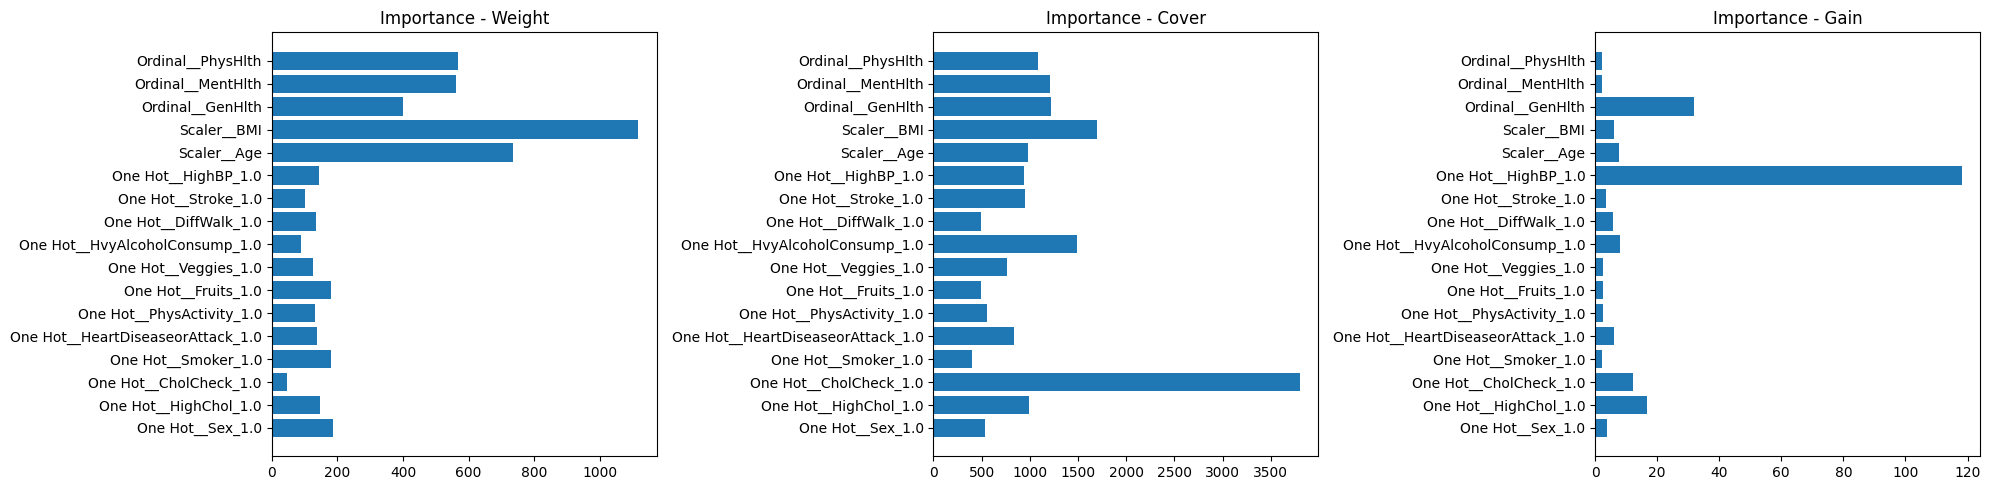

In [ ]:
# Crear una figura con 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Peso
ax[0].barh(list(mapped_importances_weight.keys()), list(mapped_importances_weight.values()))
ax[0].set_title('Importance - Weight')

# Cobertura
ax[1].barh(list(mapped_importances_cover.keys()), list(mapped_importances_cover.values()))
ax[1].set_title('Importance - Cover')

# Ganancia
ax[2].barh(list(mapped_importances_gain.keys()), list(mapped_importances_gain.values()))
ax[2].set_title('Importance - Gain')

# Ajustar el dise√±o y mostrar la figura con los subplots
plt.tight_layout()
plt.show()


Seg√∫n los resultados obtenidos en el an√°lisis de los m√©todos Weight, Gain y Cover, se identificaron diferentes variables como las m√°s relevantes. La Variable BMI se destac√≥ en Weight, CholCheck en Gain y HighBP en Cover. Estos hallazgos resaltan la importancia de las variables relacionadas con el historial m√©dico de la persona, como √çndice de Masa Corporal , niveles elevados de colesterol y Presi√≥n Arterial Alta. Este hallazgo resulta l√≥gico, considerando que la diabetes es una enfermedad que impacta en todo el organismo, lo que sugiere la posible presencia de otras condiciones asociadas en quienes la padecen.


Cada uno de los m√©todos Weight, Gain y Cover proporciona una perspectiva diferente sobre la relevancia de las caracter√≠sticas en el modelo:


- Weight se refiere a la frecuencia con la que una caracter√≠stica aparece en los √°rboles de ensamble, una caracter√≠stica con un alto valor de peso simplemente significa que se ha utilizado m√°s a menudo en los √°rboles del modelo.
- Gain representa la mejora promedio en la precisi√≥n que aporta una caracter√≠stica a los √°rboles, una caracter√≠stica con un alto valor de ganancia significa que ha contribuido a aumentar significativamente la precisi√≥n del modelo.
- Cover indica el promedio de cover de las observaciones de una caracter√≠stica, relacionado con el n√∫mero de muestras afectadas por su divisi√≥n, una caracter√≠stica con un alto valor de cover significa que ha afectado a un gran n√∫mero de muestras.


Estos m√©todos pueden dar importancias variadas a las caracter√≠sticas dependiendo del objetivo. Por ejemplo, una caracter√≠stica podr√≠a tener un alto peso (Weight) al ser utilizada con frecuencia en los √°rboles, pero su contribuci√≥n a la mejora de las predicciones (Gain) podr√≠a ser baja. De manera similar, una caracter√≠stica podr√≠a tener un bajo Weight pero un alto Cover, afectando a un gran n√∫mero de observaciones cuando se usa. No existe un valor espec√≠fico que defina una caracter√≠stica como "buena" o "mala" bas√°ndose √∫nicamente en Weight, Gain o Cover, ya que estos valores dependen de diferentes factores como la frecuencia de uso, la mejora en la precisi√≥n y la cobertura de las muestras, respectivamente.


Este metodo no esta libre de debilidades, por ejemplo, caracter√≠sticas con numerosas categor√≠as o valores √∫nicos pueden mostrar una importancia inflada. Adem√°s, la importancia de las caracter√≠sticas puede variar con diferentes conjuntos de entrenamiento, volvi√©ndose inestable. A pesar de estas limitaciones, la evaluaci√≥n de la importancia de las caracter√≠sticas sigue siendo √∫til para obtener una visi√≥n inicial de qu√© atributos son relevantes para el modelo.


## 4. M√©todos Agn√≥sticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la secci√≥n anterior, Dr. Simi le pide implementar un **m√©todo de permutaci√≥n** que le permita observar la importancia de las features. Visualice los resultados de este m√©todo en un gr√°fico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviaci√≥n est√°ndar de sus resultados (¬øQu√© se√±ala est√°?). Adem√°s, responda las siguientes preguntas:


- ¬øC√≥mo mide la importancia de las features su propuesta?
- ¬øQu√© features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¬øTienen sentido?
- ¬øC√≥mo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del m√©todo implementado.

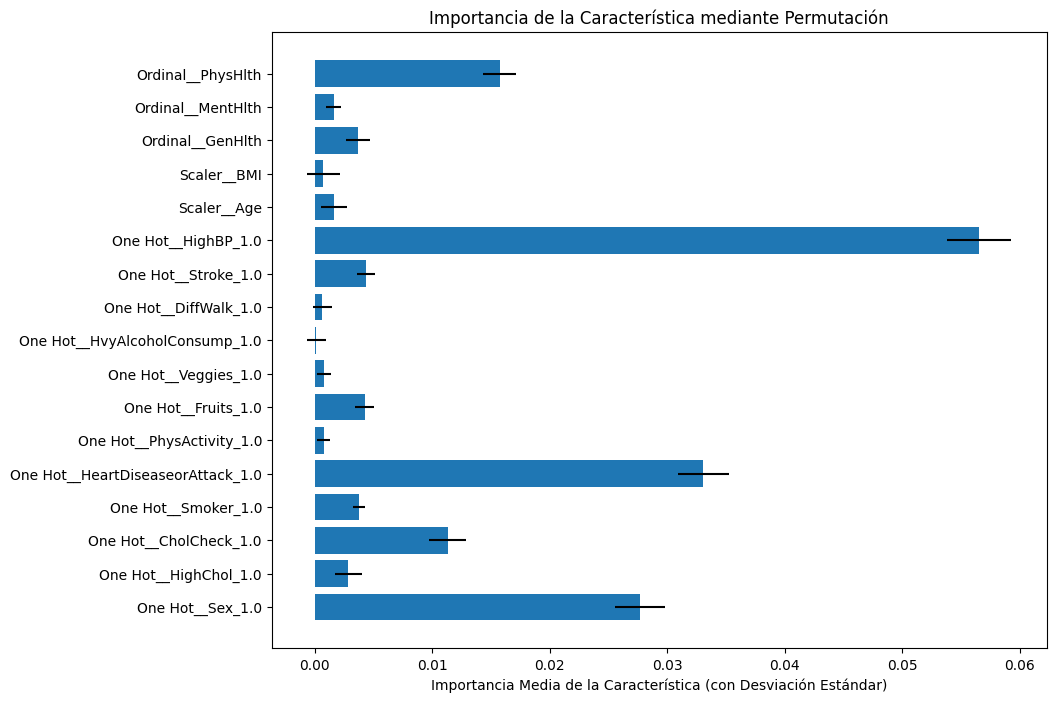

In [ ]:
# Asegurarse de tener los nombres de las caracter√≠sticas correctos
feature_names = XGBoost_clas.named_steps['preprocessing'].get_feature_names_out()

# Ejecutar el m√©todo de permutaci√≥n 30 veces
results = permutation_importance(XGBoost_clas, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Obtener la importancia media y la desviaci√≥n est√°ndar
importances_mean = results.importances_mean
importances_std = results.importances_std

# Visualizar la importancia de las caracter√≠sticas
plt.figure(figsize=(10, 8))
plt.barh(feature_names, importances_mean, xerr=importances_std)
plt.xlabel('Importancia Media de la Caracter√≠stica (con Desviaci√≥n Est√°ndar)')
plt.title('Importancia de la Caracter√≠stica mediante Permutaci√≥n')
plt.show()




La desviaci√≥n est√°ndar en este caso revela que la importancia de las variables no es constante. Esta variabilidad se debe al m√©todo de permutaci√≥n, el cual es una t√©cnica de aproximaci√≥n y la importancia de las caracter√≠sticas puede experimentar peque√±as variaciones en cada ejecuci√≥n del m√©todo.


La medici√≥n de la importancia se hace mediante el m√©todo de importancia de la permutaci√≥n. Se eval√∫a la relevancia de una caracter√≠stica al permutar aleatoriamente sus valores en el conjunto de datos y cuantificar la disminuci√≥n en la precisi√≥n del modelo como resultado.


Entre las 5 caracter√≠sticas con mayor impacto son: Presi√≥n Arterial Alta (HighBP), HeartDisorderAttack, Genero, Salud general (Physhlth) y (CholCheck). Estas variables son coherentes, dado que son factores de riesgo conocidos para la diabetes. Adem√°s, la salud general puede estar vinculada a la diabetes, ya que las personas afectadas por esta condici√≥n tienden a tener una salud general m√°s delicada.


En cuanto al cambio con rspecto a antes, las caracter√≠sticas m√°s relevantes son consistentes, aunque el orden de importancia varia. Esta variaci√≥n se debe a la naturaleza aproximada del m√©todo de permutaci√≥n, que provoca peque√±as alteraciones en la importancia de las caracter√≠sticas en cada ejecuci√≥n del proceso.


En cuanto a ventajas:


- Interpretabilidad: Este m√©todo es altamente comprensible y f√°cil de explicar. Eval√∫a la relevancia de las caracter√≠sticas al medir la disminuci√≥n en la precisi√≥n del modelo cuando los valores de una caracter√≠stica se permutan aleatoriamente.


- Manejo de caracter√≠sticas irrelevantes y redundantes: Este enfoque es capaz de identificar caracter√≠sticas que no aportan a la precisi√≥n del modelo. Si al permutar los valores de una caracter√≠stica no se afecta la precisi√≥n del modelo, es probable que dicha caracter√≠stica sea irrelevante.




- Generalidad: Puede ser aplicado a cualquier modelo supervisado, a diferencia de otros m√©todos de evaluaci√≥n de importancia de caracter√≠sticas que se restringen a ciertos tipos de modelos.


En cuanto a desventajas:


- Costo computacional: La evaluaci√≥n de la importancia mediante permutaci√≥n puede ser costosa computacionalmente, especialmente en conjuntos de datos con numerosas caracter√≠sticas, ya que requiere reajustar el modelo para cada una de ellas.


- Correlaci√≥n entre caracter√≠sticas: Si dos caracter√≠sticas est√°n altamente correlacionadas, permutar una de ellas puede no afectar significativamente la precisi√≥n del modelo, dado que la otra caracter√≠stica proporciona informaci√≥n similar. Esto puede conducir a una subestimaci√≥n de la importancia de dichas caracter√≠sticas.


- Ruido aleatorio: Al basarse en la permutaci√≥n aleatoria de valores de caracter√≠sticas, este m√©todo puede ser susceptible al ruido aleatorio. Aunque repetir el proceso y obtener un promedio puede ayudar a mitigar este problema, tambi√©n conlleva un aumento en el costo computacional.






## 5. M√©todos Agn√≥sticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber c√≥mo funciona el modelo de predicci√≥n a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmac√©utico le pide calcular los *shap values* de su modelo. ¬øQu√© representa cada n√∫mero en su resultado? ¬øEs posible atribuir un significado a la positividad/negatividad de cada valor?

In [ ]:
!pip install shap

In [ ]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [ ]:
#Para obtener los nombres
feature_names = ct.get_feature_names_out()

#Aplicamos el procesamiento al conjunto X
X = df.drop(columns=['Diabetes'])
X_prep = pd.DataFrame(ct.transform(X), columns=feature_names)

# Crear el explainer con el conjunto
xgboost_model = XGBoost_clas.named_steps['model']
explainer = shap.TreeExplainer(xgboost_model)

# Calcular los shapley values
shap_values = explainer.shap_values(X_prep)

[04:17:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [ ]:
print(shap_values)

[[-0.00460456 -0.3848604   0.02467936 ...  0.19915318 -0.22279075
   0.08616973]
 [ 0.05632673  0.14292245  0.01815863 ...  0.13971637  0.01248265
   0.02512943]
 [ 0.31258932 -0.297469    0.03093003 ... -0.9846991   0.0673209
   0.25670406]
 ...
 [-0.08597348  0.28478292  0.01470587 ...  0.86942726 -0.15803117
   0.04650539]
 [-0.1685042   0.33939835  0.02485717 ...  0.80530185  0.04959565
   0.08810985]
 [ 0.03591182  0.23616262  0.02084731 ... -0.59756786  0.09190472
   0.00486993]]


In [ ]:
# Visualizar los SHAP values para una instancia espec√≠fica (en este caso la primera)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_prep.iloc[0,:])


Los valores SHAP representan la contribuci√≥n espec√≠fica de cada caracter√≠stica a la predicci√≥n de un modelo en comparaci√≥n con la predicci√≥n promedio del mismo. Estos valores sirven para interpretar c√≥mo cada caracter√≠stica afecta las predicciones.

Un valor SHAP positivo para una caracter√≠stica se√±ala que esta aumenta la predicci√≥n del modelo para esa observaci√≥n respecto a la predicci√≥n promedio. Por el contrario, un valor SHAP negativo indica que la caracter√≠stica reduce la predicci√≥n del modelo para esa observaci√≥n.

La magnitud absoluta de los valores SHAP refleja el impacto de cada caracter√≠stica en la predicci√≥n. Asi que aquellas con mayores valores absolutos de SHAP se consideran m√°s relevantes para el modelo en t√©rminos predictivos.

Los valores SHAP respetan la propiedad aditiva de los juegos cooperativos. Esto implica que la suma de los valores SHAP de todas las caracter√≠sticas es igual a la diferencia entre la predicci√≥n del modelo para una observaci√≥n espec√≠fica y la predicci√≥n promedio del modelo.

A diferencia de otros m√©todos de evaluaci√≥n de la importancia de caracter√≠sticas, los valores SHAP capturan las interacciones entre las caracter√≠sticas. Esta consideraci√≥n proporciona una visi√≥n m√°s completa de la importancia relativa de las caracter√≠sticas en el modelo.

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¬øQu√© variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
- ¬øExiste alg√∫n patr√≥n com√∫n entre las instancias analizadas?
- ¬øEs posible generalizar estas conclusiones a todo el dataset?

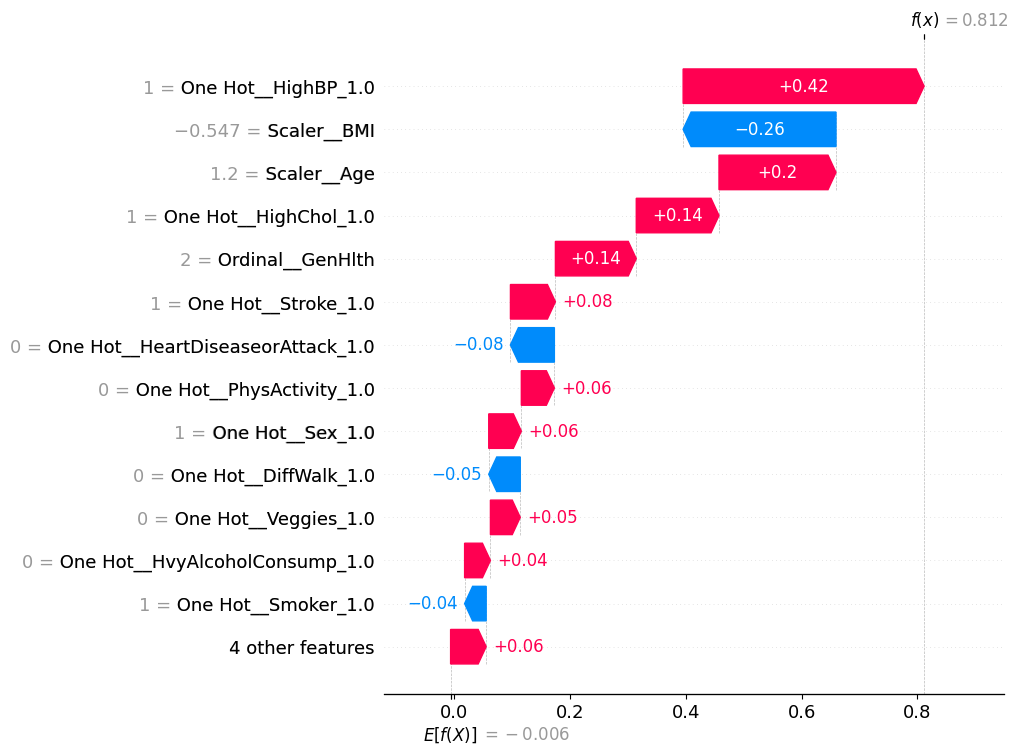

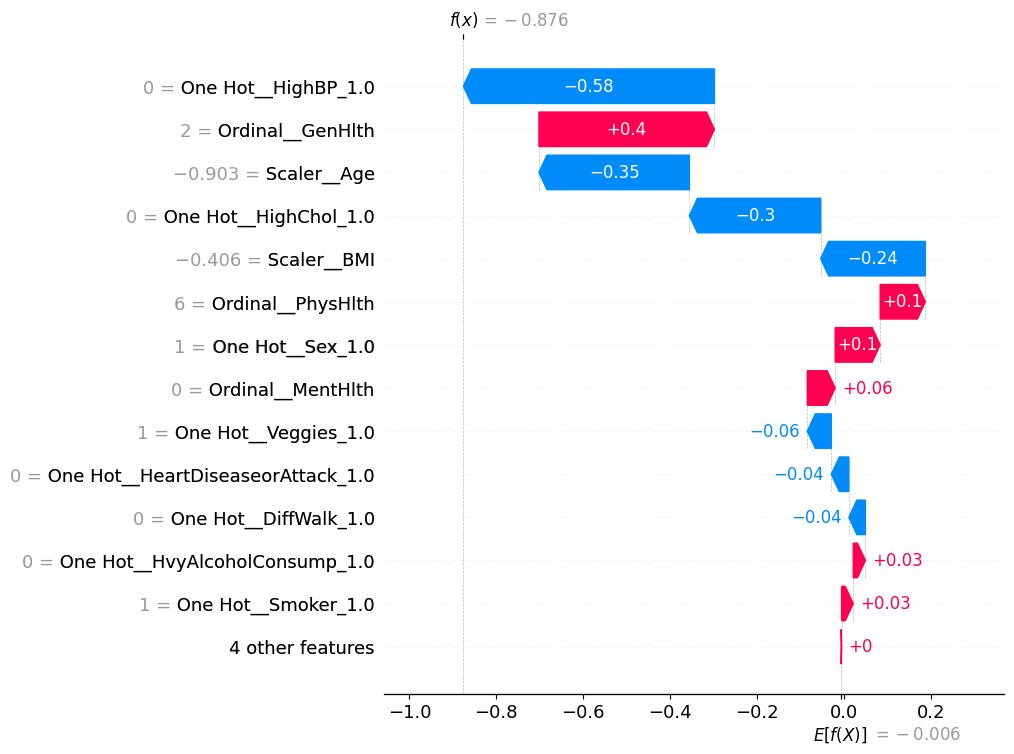

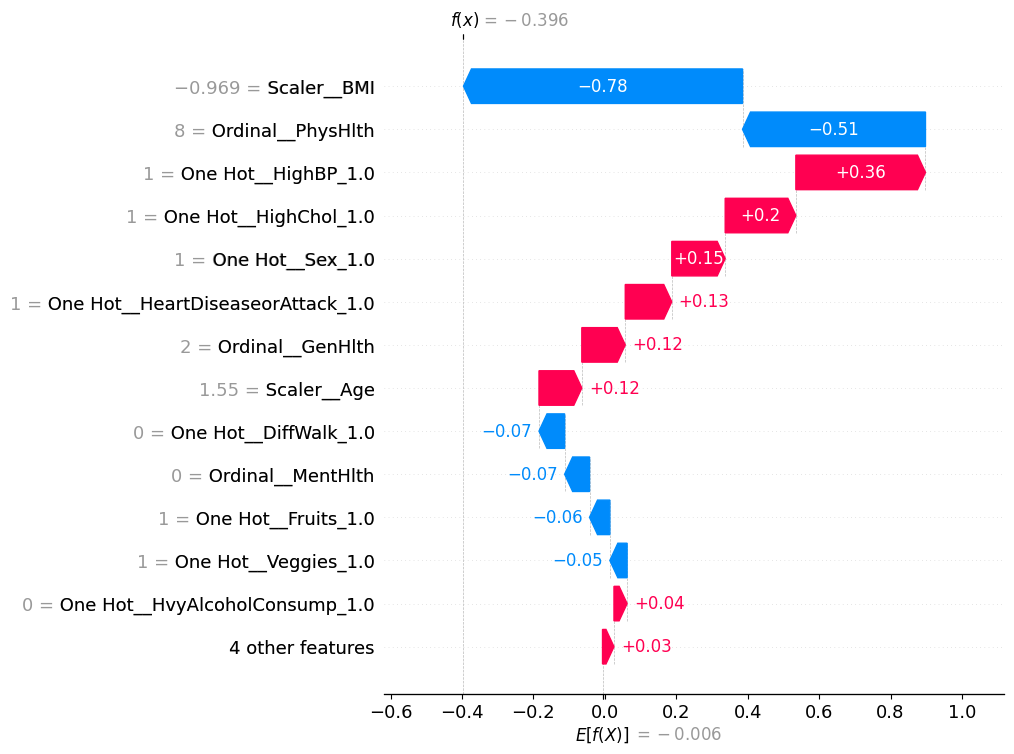

In [ ]:

shap.initjs()
shap_values_df = pd.DataFrame(shap_values, columns=feature_names)
# Obtener el aporte de las diferentes variables para las instancias 1, 9 y 150
instances = [1, 9, 150]


# Mostrar 10 features como m√°ximo en tu gr√°fico waterfall
max_display_features = 10

for instance in instances:
    # Convertir los valores SHAP de la instancia actual en un objeto Explanation
    explanation = shap.Explanation(values=shap_values[instance],
                                   base_values=explainer.expected_value,
                                   data=X_prep.iloc[instance],
                                   feature_names=feature_names)

    # Generar el waterfall plot para la instancia actual
    shap.plots.waterfall(explanation, max_display=max_display_features)



#for instance in instances:
 #   shap.force.waterfall(explainer.expected_value, shap_values[instance], X_prep.iloc[instance], matplotlib=True)

Los gr√°ficos ilustran como diferentes car√°cteristicas impactan en predicciones espec√≠ficas. En los casos estudiados se observa que que una presi√≥n arterial alta afecta psotivamente en la predicci√≥n (mayor probabilidad de tener diabetes), mientras que si esta es baja, afecta de manera negativa. El BMI tambi√©n tiene un efecto importante en la probabilidad de diabtes, en las tres instancias se observa que un valor negativo de este influye de manera negativa a la predicci√≥n. La edad tambi√©n es un factor a considerar, se observa que una magnitud menor afecta de manera negativa a la predicci√≥n, mientras que cuando es mayor es al contrario. Por otra parte, el nivel de colesterol es otra variable influyente, ya que cuando el nivel de colesterol es alto (igual a 1), esta variable contribuye positivamente a la predicci√≥n.


Es importante tener en cuenta que estas 3 instancias individuales no definen un patr√≥n general para los datos. Aunque algunas variables tienen un peso significativo, hay que ser cuidadosos al interpretar los valores SHAP, ya que representan promedios y no se aplican a cada caso particular.

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualizaci√≥n donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¬øQu√© diferencias existen con las conclusiones generadas a nivel de instancia?

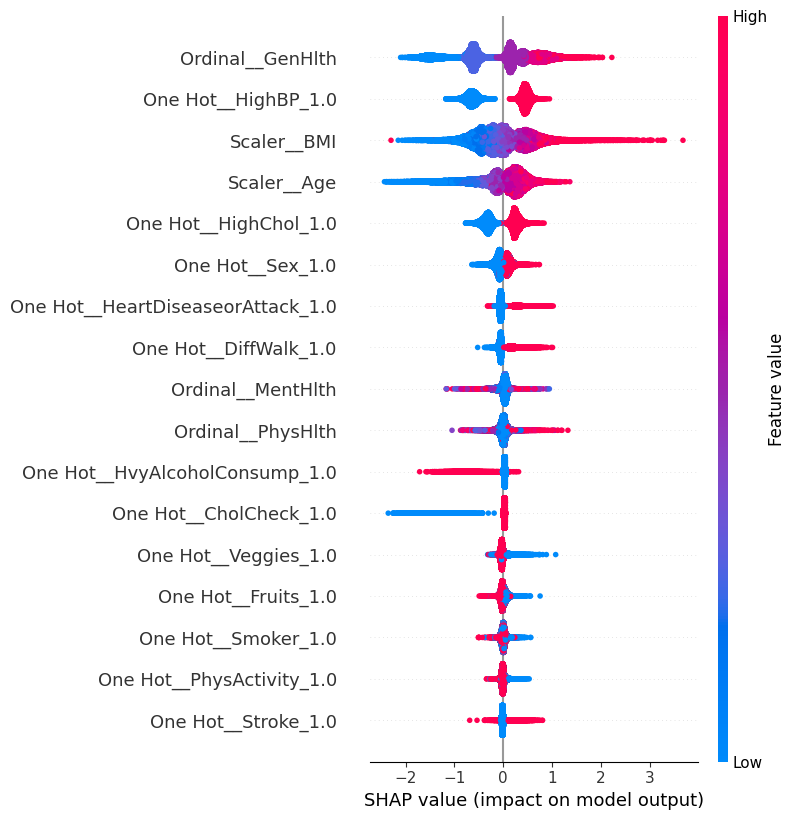

In [ ]:
shap.summary_plot(shap_values_df.values, X_prep)

Comparado con las conclusiones generadas a nivel de instancia, ahora se brinda una perspectiva m√°s amplia sobre la importancia de las caracter√≠sticas en el conjunto de datos en su totalidad, en contraste con el enfoque en casos espec√≠ficos. Esto permite identificar qu√© caracter√≠sticas son generalmente relevantes para el modelo, en lugar de aquellas que son importantes √∫nicamente para casos individuales.

Entonces,  los resultados a nivel global pueden ofrecer una visi√≥n m√°s amplia y s√≥lida sobre la importancia de las caracter√≠sticas de manera generalizable.

En el grafico se observa que las caracter√≠sticas m√°s relevantes son GenHlt, HighBP, BMI, Age y HighChol. Esto concuerda con los resultados a nivel de instancia, donde todas estas variables estuvieron en el top 5 de alguna de ellas.

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gr√°fico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¬øQu√© puede concluir de sus resultados?

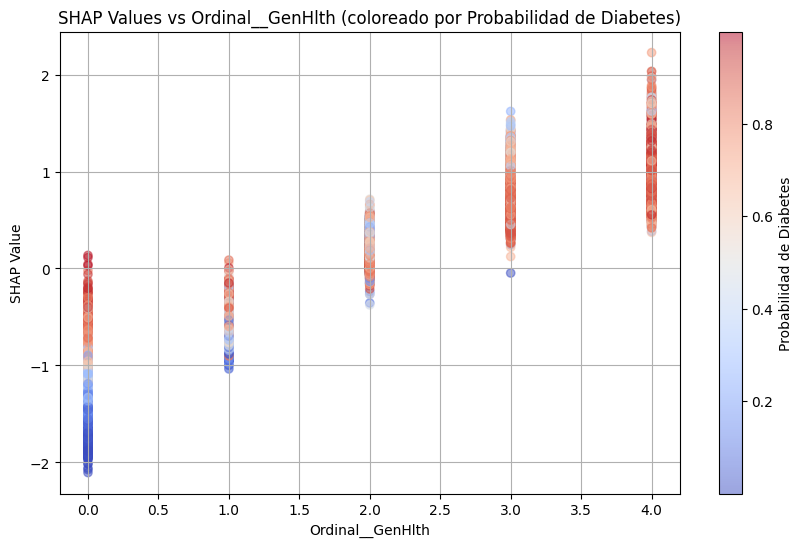

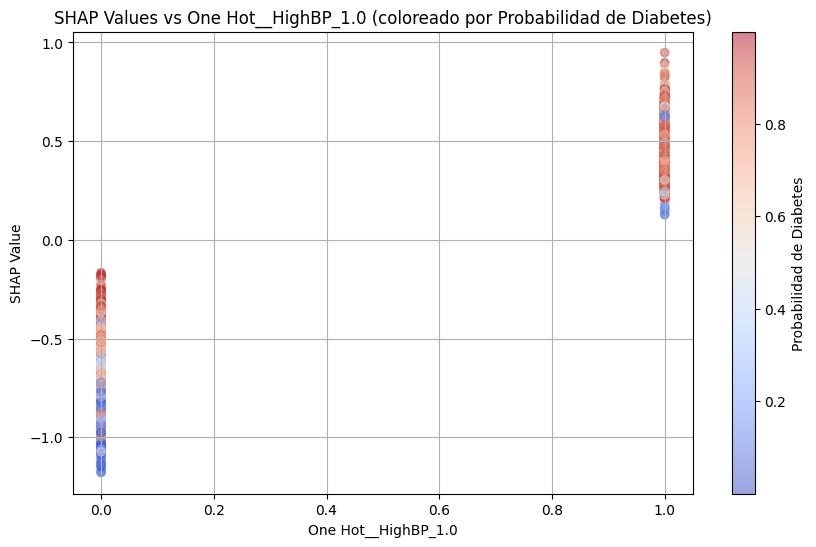

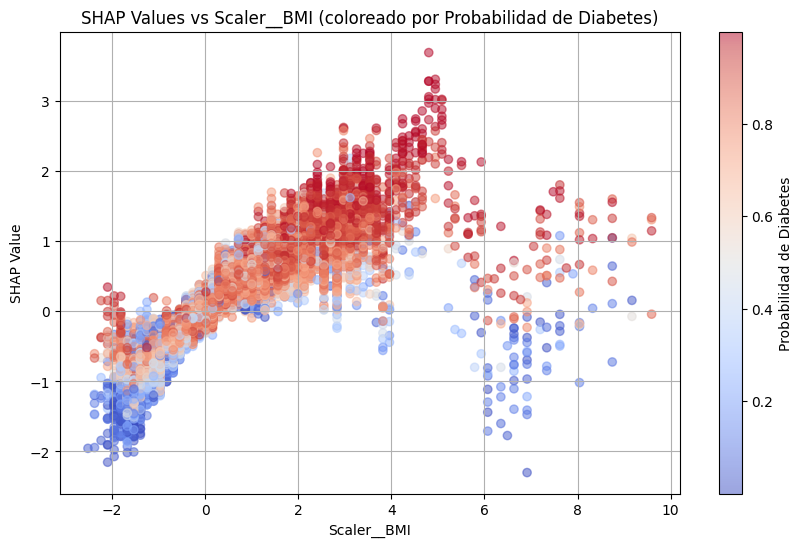

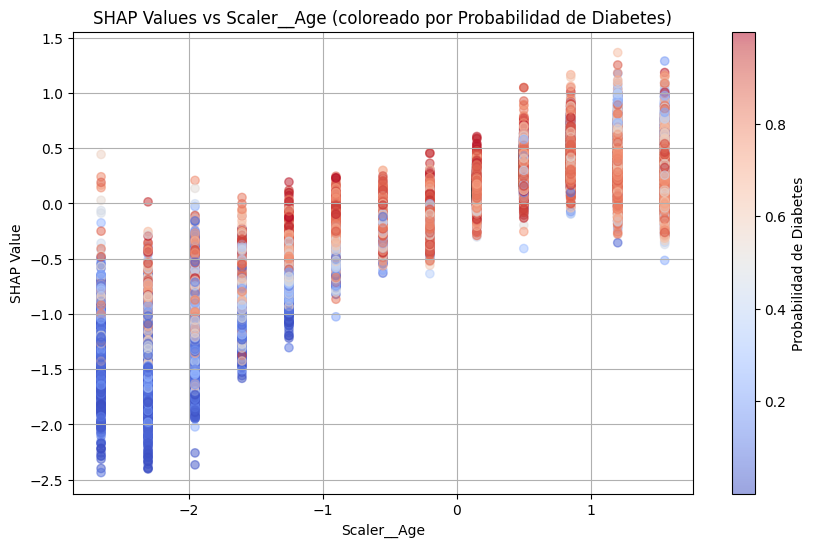

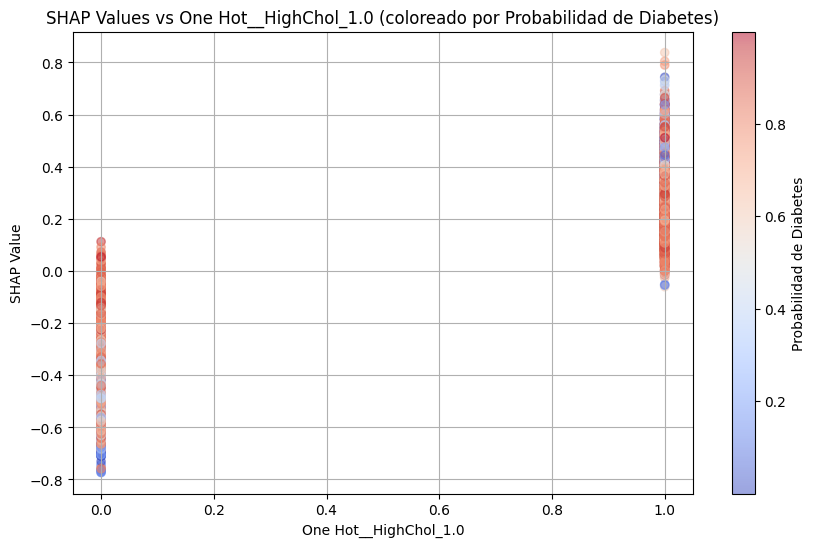

In [ ]:
# Calculamos los valores SHAP absolutos promediados
shap_values_abs_mean = np.mean(np.abs(shap_values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor importancia
feature_importance_names = X_prep.columns[np.argsort(shap_values_abs_mean)[::-1]]
#predicciones de probabilidad
probs = xgboost_model.predict_proba(X_prep)[:, 1]

# Generar gr√°ficos de dispersi√≥n
for name in feature_importance_names[:5]:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_prep[name], shap_values[:, X_prep.columns.get_loc(name)], c=probs,alpha=0.5, cmap='coolwarm')
    plt.colorbar(label='Probabilidad de Diabetes')
    plt.xlabel(name)
    plt.ylabel('SHAP Value')
    plt.title(f'SHAP Values vs {name} (coloreado por Probabilidad de Diabetes)')
    plt.grid(True)
    plt.show()

En todos los gr√°ficos se puede observar que a mayor shap es m√°s probable tener diabetes (puntos mpas rojos)

- GenHlth: Hay una mezcla de probabilidades de diabetes en cada nivel, pero los niveles m√°s altos de 'GenHlth' tienden a tener puntos m√°s rojos, lo que indica una mayor probabilidad de diabetes.

- HighBP: Los valores SHAP negativos cuando la variable es 0 y positivos cuando es 1, sugieren que tener la presi√≥n arterial alta (valor igual a 1) es un factor de riesgo seg√∫n el modelo.

- BMI:Hay una tendencia clara de que a medida que el BMI aumenta, tambi√©n lo hace el valor SHAP, lo que indica un mayor riesgo de diabetes.

- Age: Hay una tendencia que a mayor edad, el rango del SHAP se acerca m√°s a los positivos y con eso, tambi√©n se ve un aumento en la probabilidad de tener diabete.

- HighChol: Los puntos con 1 (colesterol alto) tienden a tener valores SHAP positivos, lo que indica que es un factor de riesgo para la diabetes seg√∫n el modelo.

En general, estos gr√°ficos muestran que ciertas condiciones m√©dicas (presi√≥n arterial alta, colesterol alto) y factores de riesgo (BMI, percepci√≥n de mala salud) se asocian con un mayor riesgo de diabetes seg√∫n el modelo.

Estos resultados pueden ser √∫tiles para el Dr. Simi para entender c√≥mo el modelo hace sus predicciones y potencialmente para identificar √°reas donde se podr√≠a necesitar m√°s informaci√≥n o investigaci√≥n.

### 5.5 Partial Dependence Plot (0.4 puntos)


Finalmente, se le pide generar un gr√°fico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¬øQu√© relaci√≥n existe entre la salida promedio del modelo y cada feature analizada? ¬øSon estas conclusiones generalizables para todo el conjunto de datos?

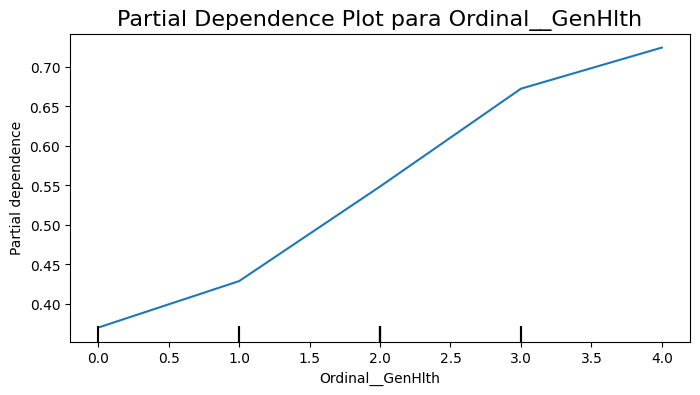

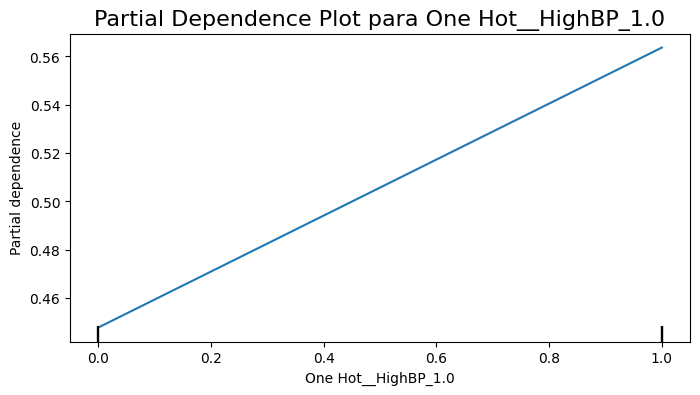

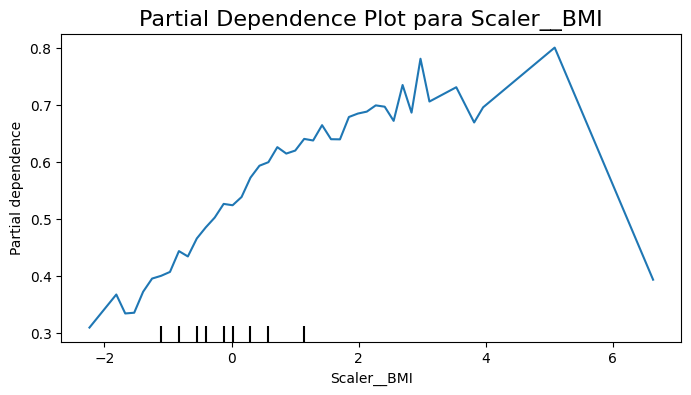

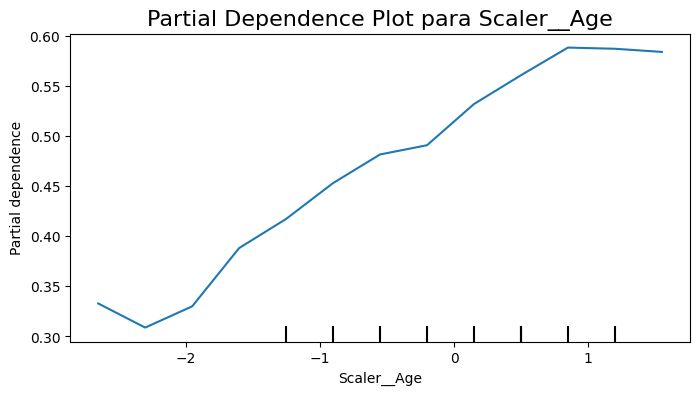

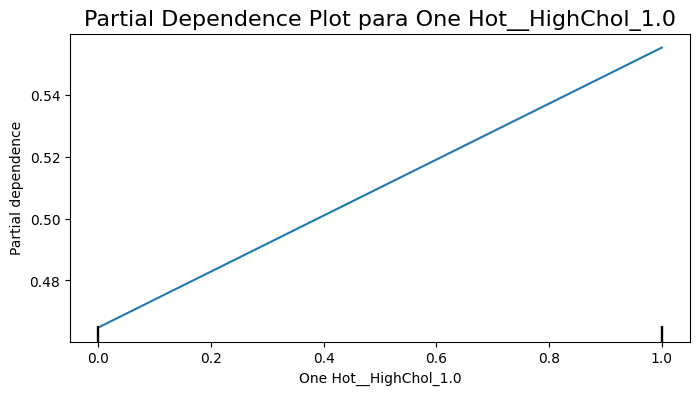

In [ ]:
# Elegimos una submuestra aleatoria de 1000 observaciones de X_test
np.random.seed(0)  # Para reproducibilidad
subsample_indices = np.random.choice(X_prep.shape[0], 1000, replace=False)
X_subsample = X_prep.iloc[subsample_indices]

# Ahora generamos los Partial Dependence Plots para las 5 caracter√≠sticas m√°s importantes
for feature in feature_importance_names[:5]:
    fig, ax = plt.subplots(figsize=(8, 4))
    PartialDependenceDisplay.from_estimator(
        xgboost_model, X_subsample, [feature], ax=ax, grid_resolution=50, kind='average'
    )
    ax.set_title(f"Partial Dependence Plot para {feature}", fontsize=16)
    ax.set_xlabel(feature, fontsize=12, rotation=45)
    ax.set_ylabel("Predicted probability change", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

Los Partial Dependence Plots (PDP) muestran c√≥mo la predicci√≥n promedio de un modelo cambia con diferentes valores de una caracter√≠stica, manteniendo todas las dem√°s caracter√≠sticas en su valor promedio.

- GenHlth: El PDP muestra una tendencia ascendente clara, indicando que a medida que empeora la percepci√≥n de la salud general, el modelo predice una mayor probabilidad de diabetes.

- HighBP: El PDP muestra un incremento lineal, lo que significa que la presencia de presi√≥n arterial alta (valor de 1) se asocia con un aumento en la probabilidad de diabetes seg√∫n el modelo.

- BMI: Aqu√≠ vemos una relaci√≥n m√°s compleja. A medida que aumenta el BMI, tambi√©n lo hace la predicci√≥n promedio de la probabilidad de diabetes, pero la relaci√≥n no es completamente lineal y presenta cierta variabilidad. Esto podr√≠a reflejar c√≥mo la relaci√≥n entre BMI y diabetes es m√°s compleja y posiblemente afectada por otros factores.

- Age:  A medida que la edad aumenta, la probabilidad de diabetes tambi√©n aumenta. Hacia el extremo derecho del gr√°fico, donde los valores estandarizados de la edad son m√°s altos (lo que indicar√≠a una edad m√°s avanzada), la probabilidad se estabiliza. Esto podr√≠a sugerir que una vez que se alcanza cierta edad, el modelo no considera aumentos adicionales en la edad como un riesgo significativamente mayor.

- HighChol: Similar al PDP para la presi√≥n arterial alta, muestra un incremento lineal en la probabilidad de diabetes cuando el colesterol alto est√° presente (valor de 1

No se puede afirmar que las conclusiones son generalizables ya que puede que el conjunto de datos aleatorios no capture todas las variaciones dentro del conjunto de datos completo, adem√°s, las relaciones observadas en los gr√°ficos de dependencia parcial pueden no ser causales. Los PDP asumen que las caracter√≠sticas son independientes entre s√≠, lo que rara vez ocurre en los datos reales. Las interacciones entre caracter√≠sticas pueden influir en las predicciones de maneras que los PDP no pueden capturar.

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Despu√©s de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisi√≥n tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas se√±ale a **cu√°nta poblaci√≥n** es posible explicar con estas reglas e indique la **precisi√≥n** que poseen las reglas en la totalidad de los datos. ¬øTienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta se√±alando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
!pip install alibi

In [ ]:
from alibi.explainers import AnchorTabular

In [ ]:
def predict_fn(input_data):
    return xgboost_model.predict(input_data)

explainer = AnchorTabular(predict_fn, feature_names, seed=1)
explainer.fit(X_train.to_numpy())


#indices a procesar
idx_values = [1000, 3001, 5751]

class_names = ["Sin Diabetes", "Con Diabetes"]

for idx in idx_values:
    print(f"\nExplanation for instance at index {idx}:")
    print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
    explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
    print('Anchor: %s' % (' AND '.join(explanation.anchor)))
    print('Precision: %.2f' % explanation.precision)
    print('Coverage: %.2f' % explanation.coverage)



Explanation for instance at index 1000:
Prediction:  Con Diabetes
Anchor: One Hot__CholCheck_1.0 > 0.00
Precision: 0.99
Coverage: 0.52

Explanation for instance at index 3001:
Prediction:  Con Diabetes
Anchor: One Hot__HighChol_1.0 > 0.00 AND Ordinal__PhysHlth > 0.00 AND Scaler__Age > 2.00 AND One Hot__PhysActivity_1.0 > 0.00 AND One Hot__HeartDiseaseorAttack_1.0 > 29.00
Precision: 0.97
Coverage: 0.02

Explanation for instance at index 5751:
Prediction:  Con Diabetes
Anchor: One Hot__CholCheck_1.0 > 0.00 AND One Hot__HighChol_1.0 > 0.00
Precision: 0.99
Coverage: 0.24


Estas reglas muestran una precisi√≥n notable, lo que indica que son predictivas en un alto porcentaje, ya sea para predecir la presencia o ausencia de diabetes en un individuo.


La primera regla de predicci√≥n para el individuo de √≠ndice 1000 indica que la condici√≥n principal para predecir la presencia de diabetes es la detecci√≥n positiva de la variable "CholCheck" ("One Hot__CholCheck_1.0 > 0.00"). Esta √∫nica condici√≥n tiene una alta precisi√≥n del 99%, lo que significa que en el 99% de los casos en que se encuentra esta condici√≥n, la predicci√≥n de diabetes es acertada. Adem√°s, esta regla se aplica al 52% de la muestra total, lo que indica que una cantidad considerable de casos dentro de la muestra comparten esta condici√≥n espec√≠fica de que la detecci√≥n positiva de "CholCheck" es un indicador relevante para la presencia de diabetes.


La segunda regla establece que, para predecir la presencia de diabetes en un individuo espec√≠fico (√≠ndice 3001), se requiere la conjunci√≥n de m√∫ltiples condiciones: altos niveles de colesterol, salud f√≠sica sub√≥ptima, edad escalada mayor que 2, alta actividad f√≠sica y antecedentes de enfermedad card√≠aca o ataques card√≠acos. Esta combinaci√≥n particular tiene una precisi√≥n del 97%, lo que significa que en el 97% de los casos en que se cumplen estas condiciones, la predicci√≥n es acertada. Aun asi, esta regla solo se aplica al 0.02% de la muestra.


La tercera regla para predecir la presencia de diabetes en el individuo de √≠ndice 5751 se basa en la presencia de dos condiciones espec√≠ficas: la detecci√≥n positiva de colesterol ("One Hot__CholCheck_1.0 > 0.00") y la existencia de niveles altos de colesterol ("One Hot__HighChol_1.0 > 0.00"). Esta combinaci√≥n de condiciones tiene una alta precisi√≥n del 99%, lo que significa que en el 99% de los casos en que estas condiciones se cumplen simult√°neamente, la predicci√≥n de diabetes es correcta. Sin embargo, esta regla se aplica a aproximadamente el 24% de la muestra total, lo que indica que es un patr√≥n m√°s com√∫n pero a√∫n selectivo dentro del conjunto de datos analizados.


A pesar de que estas reglas no abarcan un porcentaje muy alto del conjunto de datos para la predicci√≥n con diabetes (7%), son relevantes en una variedad decente de situaciones, lo que las convierte en herramientas valiosas para interpretar las predicciones del modelo en diferentes escenarios. A pesar de no cubrir todos los casos, su alta precisi√≥n en los segmentos de poblaci√≥n que abarcan las hace √∫tiles y confiables para la interpretaci√≥n del modelo.




# Retrospectiva... (1.0 puntos)

En base a los diferentes m√©todos que implementa y ha comentado en este laboratorio, comente qu√© m√©todos le permiten entregar mejores conclusiones para la tarea de clasificaci√≥n de diabetes. Por otro lado, ¬øqu√© m√©todos son m√°s √∫tiles para el problema del doctor Simi, m√©todos agnosticos locales o globales?

> Dependiendo de la perspectiva que busquemos, cada m√©todo tiene sus puntos fuertes y limitaciones.

La Importancia de las Caracter√≠sticas es un m√©todo global que ofrece una panor√°mica sobre qu√© rasgos son m√°s relevantes para el modelo en su conjunto. Resulta √∫til para obtener una comprensi√≥n general de los aspectos considerados por el modelo al tomar decisiones, pero no revela c√≥mo esas caracter√≠sticas influyen individualmente en cada predicci√≥n.

El m√©todo SHAP (SHapley Additive exPlanations) constituye tanto un enfoque local como global. A nivel local, proporciona una explicaci√≥n detallada de c√≥mo cada caracter√≠stica contribuye a la predicci√≥n para una instancia individual, lo cual es valioso para comprender el razonamiento del modelo en casos espec√≠ficos. A nivel global, brinda una visi√≥n general de c√≥mo las caracter√≠sticas influyen en las predicciones del modelo en general. Los gr√°ficos de dependencia de SHAP y las representaciones de la importancia de las caracter√≠sticas ofrecen una visi√≥n detallada y completa de las decisiones del modelo.

Por otro lado, las Anchor Rules constituyen un m√©todo local que ofrece reglas claras y f√°cilmente interpretables que explican por qu√© el modelo realiz√≥ una predicci√≥n espec√≠fica. Esto resulta especialmente √∫til para proporcionar explicaciones simples y comprensibles a personas no expertas en el modelo, como los pacientes en este caso.

Los gr√°ficos de dependencia parcial (Partial Dependence Plots, PDP) ofrecen un enfoque m√°s global y son √∫tiles para entender c√≥mo los diferentes niveles de una caracter√≠stica en particular afectan la salida promedio del modelo.

En la tarea de clasificaci√≥n de la diabetes, tanto SHAP como las Reglas de Anclaje ofrecen conclusiones detalladas y √∫tiles. SHAP proporciona una visi√≥n minuciosa de c√≥mo las caracter√≠sticas afectan las predicciones tanto a nivel individual como general, mientras que las Reglas de Anclaje ofrecen explicaciones simples y comprensibles para las predicciones individuales.

Respecto a la consulta del Dr. Simi, la elecci√≥n del m√©todo depende del prop√≥sito de la explicaci√≥n. Si el Dr. Simi necesita entender las decisiones del modelo de manera general para mejorar el modelo o para verificar su coherencia con el entendimiento m√©dico de la diabetes, los m√©todos globales como la Importancia de las Caracter√≠sticas, PDP y SHAP a nivel global ser√≠an m√°s √∫tiles. Por otro lado, si el Dr. Simi necesita explicar a un paciente en particular por qu√© el modelo realiz√≥ una predicci√≥n espec√≠fica, entonces los m√©todos locales como SHAP a nivel individual y las Reglas de Anclaje ser√≠an m√°s apropiados, dado que se optimizan las decisiones y predicciones para cada grupo, determinando si tienen diabetes o no. La capacidad de comprender el razonamiento detr√°s de una predicci√≥n puede ayudar a los pacientes a confiar m√°s en el diagn√≥stico o pron√≥stico, lo cual es especialmente relevante en el √°mbito m√©dico, donde la confianza del paciente puede influir en su abordaje frente a la enfermedad.

# Conclusi√≥n
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>